In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive")

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('IMDB_Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 29.9 MB/s 
     |████████████████████████████████| 596 kB 66.8 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 61.9 MB/s 
     |████████████████████████████████| 880 kB 58.8 MB/s 


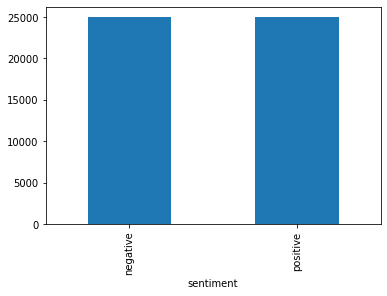

In [ ]:
df.groupby(['sentiment']).size().plot.bar()

### Check if BERT tokenizer and AutoTokenizer are the same in terms of output dimensions.

In [ ]:
'''
from transformers import BertTokenizer,AutoTokenizer

# BERT Tokenizer
print("BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
encoded=tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
print(encoded.keys())
print(encoded['input_ids'].size())
print(encoded['token_type_ids'].size())
print(encoded['attention_mask'].size())

# AutoTokenizer
print("")
print("AutoTokenizer")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True) # use a different tokenizer
encoded=tokenizer(text, padding='max_length', max_length = 512, truncation=True,return_tensors="pt",return_offsets_mapping=False)
print(encoded.keys())
print(encoded['input_ids'].size())
print(encoded['token_type_ids'].size())
print(encoded['attention_mask'].size())
'''

'\nfrom transformers import BertTokenizer,AutoTokenizer\n\n# BERT Tokenizer\nprint("BERT Tokenizer")\ntokenizer = BertTokenizer.from_pretrained(\'bert-base-cased\')\nencoded=tokenizer(text, padding=\'max_length\', max_length = 512, truncation=True, return_tensors="pt")\nprint(encoded.keys())\nprint(encoded[\'input_ids\'].size())\nprint(encoded[\'token_type_ids\'].size())\nprint(encoded[\'attention_mask\'].size())\n\n# AutoTokenizer\nprint("")\nprint("AutoTokenizer")\ntokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True) # use a different tokenizer\nencoded=tokenizer(text, padding=\'max_length\', max_length = 512, truncation=True,return_tensors="pt",return_offsets_mapping=False)\nprint(encoded.keys())\nprint(encoded[\'input_ids\'].size())\nprint(encoded[\'token_type_ids\'].size())\nprint(encoded[\'attention_mask\'].size())\n'

### Dataset, model, training loop, evaluation ...

Dataset

In [4]:
import torch
import numpy as np
# from transformers import BertTokenizer，AutoTokenizer
from transformers import AutoTokenizer

# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True) # use a different tokenizer
labels = {'positive':0,
          'negative':1
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['sentiment']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt",return_offsets_mapping=False) for text in df['review']] 
                                # added return_offsets_mapping=True

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Train-validation split

In [5]:
np.random.seed(0)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=1), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

40000 5000 5000


Define the model

In [6]:
from torch import nn
from transformers import BertModel, BertConfig

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        config = BertConfig.from_pretrained("bert-base-cased", output_attentions=True)
        self.bert = BertModel.from_pretrained('bert-base-cased',config=config)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output, attentions = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        '''
        attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True) 
        Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).
        '''
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer, attentions

Training loop (if using saved model for inference, don't run training loop)

In [7]:
#@title

from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train = Dataset(train_data)
    validation = Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(validation, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = Adam(model.parameters(), lr= learning_rate)
    criterion = nn.CrossEntropyLoss()

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
           
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output, _ = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output, _ = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
    
    return model

In [ ]:
EPOCHS = 3
model = BertClassifier()
LR = 1e-6
              
model = train(model, df_train, df_val, LR, EPOCHS)
torch.save(model.state_dict(), "./sentiment_analysis_{}_epoch.pth".format(EPOCHS),)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5000/5000 [1:02:24<00:00,  1.34it/s]


Epochs: 1 | Train Loss:  0.048                 | Train Accuracy:  0.846                 | Val Loss:  0.029                 | Val Accuracy:  0.912


100%|██████████| 5000/5000 [1:02:32<00:00,  1.33it/s]


Epochs: 2 | Train Loss:  0.023                 | Train Accuracy:  0.934                 | Val Loss:  0.026                 | Val Accuracy:  0.921


100%|██████████| 5000/5000 [1:02:32<00:00,  1.33it/s]


Epochs: 3 | Train Loss:  0.017                 | Train Accuracy:  0.956                 | Val Loss:  0.027                 | Val Accuracy:  0.919


Load checkpoint.

In [ ]:
state_dict = torch.load("./sentiment_analysis_3_epoch.pth", map_location="cpu")
model = BertClassifier()
missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Extract attention weights.

prediction and attention weights

In [ ]:
#@title
import numpy as np
# import torch
from transformers import BertModel, BertConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validation = Dataset(df_val)
val_dataloader = torch.utils.data.DataLoader(validation, batch_size=8)
if torch.cuda.is_available(): model = model.cuda()

attentions = [] # all attention weights
outputs = [] # predicted outputs
gt = [] # ground truth
'''
attention_1 = [] # store all the attention weights that are correctly classified
attention_2 = [] # store all the attention weights that are incorrectly classified
output_1 = [] # store all the outputs that are correctly classified
output_2 = [] # store all the outputs that are incorrectly classified
'''

# Perform inference on first 4 batches (validation set).
i = 0
model.eval()
with torch.no_grad():
    for val_input, val_label in val_dataloader:
       val_label = val_label.to(device)
       mask = val_input['attention_mask'].to(device)
       input_id = val_input['input_ids'].squeeze(1).to(device)
       output, attention = model(input_id, mask)
       outputs.append(output.cpu().detach().numpy().tolist()) # predicted label
       attentions.append(attention) # attention scores 
       gt.append(val_label.cpu().detach().numpy().tolist()) # ground truth
       i += 1 
       del output
       del attention
       del mask
       del input_id
       del val_label
       # free_gpu_cache()     
       torch.cuda.empty_cache()   
       print(i)          
       if i == 10: break


'''
'Attentions' is a list (length = number of batches) of tuples.
Each tuple has following dimension: 
   Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).
'''

#attentions = attentions.to('cpu')
attns = []
for attn in attentions:
  es = []
  for e in attn:
    output_1 = torch.sum(e, dim=2)
    output_2 = torch.sum(output_1, dim=1)/12 # batch_sizex512
    es.append(output_2)
  attns.append(es)
  


In [ ]:
# Convert 'attns' to array.
attns # num_of_batch, num_of_layer, batch_size, 512 
attns = [[i.cpu().detach().numpy().tolist() for i in e] for e in attns]
attns = np.array(attns)
attns.shape # num_of_batch, num_of_layer, batch_size, 512 

(10, 12, 8, 512)

In [ ]:
attns[0,:,0,:].shape # Get the attention weights for the first record in first batch.

(12, 512)

In [ ]:
output_max = []
for e in outputs:
  output = np.argmax(e,axis=1)
  output_max.append(output.tolist())
  
print("ground truth: ",gt)
print("predicted outputs: ",output_max) # (0,0) and (3,2) are misclassified

ground truth:  [[1, 2, 2, 1, 1, 2, 2, 1], [2, 2, 1, 2, 1, 2, 1, 1], [1, 1, 2, 2, 1, 2, 1, 2], [2, 2, 1, 2, 1, 2, 1, 1], [1, 1, 1, 1, 2, 2, 2, 2], [2, 1, 1, 1, 1, 2, 1, 2], [2, 1, 2, 1, 1, 1, 1, 2], [2, 2, 1, 2, 1, 2, 1, 1], [1, 1, 1, 1, 2, 2, 1, 1], [1, 1, 1, 2, 1, 1, 2, 1]]
predicted outputs:  [[2, 2, 2, 1, 1, 2, 2, 1], [2, 2, 1, 2, 1, 2, 1, 1], [1, 1, 2, 2, 1, 2, 1, 2], [2, 2, 2, 2, 1, 1, 2, 1], [1, 1, 1, 2, 2, 2, 1, 2], [2, 1, 1, 1, 1, 2, 1, 2], [1, 2, 2, 2, 1, 1, 1, 1], [2, 2, 1, 2, 1, 2, 1, 2], [1, 1, 1, 1, 1, 2, 2, 2], [1, 1, 1, 2, 1, 1, 2, 1]]


From above, 1st record in 1st batch and 2nd record in 4th batch are misclassified. 

(0,0) and (3,2)

In [ ]:
# incorrectly classified examples
attn_1 = attns[0,:,0,:]
attn_2 = attns[3,:,2,:]

# correctly classified examples
attn_3 = attns[0,:,1,:]
attn_4 = attns[0,:,2,:]

Tokenize the text

In [ ]:
from transformers import AutoTokenizer

def tokenize_text(i):
  '''
  i: the index of the text (in valid dataset) to be tokenized
  '''
  # tokenizer = BertTokenizer.from_pretrained('bert-base-cased',use_fast=True) # return_offset_mapping is not available when using Python tokenizers
  tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', use_fast=True)
  encoded=tokenizer(list(df_val['essay'])[i], padding='max_length', max_length = 512, truncation=True, return_tensors="pt",return_offsets_mapping=True) 



  # encoded['offset_mapping'][0] contains token to offset mapping
  text = list(df_val['essay'])[i]
  text_split = []
  for offset in encoded['offset_mapping'][0]:
    text_split.append(text[offset[0]:offset[1]])
  
  return text_split

  # 'text_split' is a list of tokens
  # print(text_split)

Visualization: highlight most attented words.

[How to hightlight text](https://stackoverflow.com/questions/35731194/how-to-highlight-a-word-found-in-a-text-file)

In [ ]:
#@title

def highlight_tokens_by_attention(text, weights):

  # tokenize the text
  # tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  # tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
  
  '''
  # scale the attention weights
  max_weight = max(weights)
  weights_scaled = weights/max_weight
  '''

  weight_dict = {}
  for e in zip(range(len(text)), weights):
    weight_dict[e[0]] = e[1]
  
  
  # select a list of most attended words
  most_attended_words = sorted(weight_dict.items(), key =
             lambda kv:(kv[1], kv[0]),reverse=True)[:20]
  
  
  '''
  for w in most_attended_words:
    # print(w)
    text_untokenized=text_untokenized.replace(text[w[0]], '\033[44;33m{}\033[m'.format(text[w[0]]))
  '''
  # print(most_attended_words)
  text_result = ''
  most_attended_words = [t[0] for t in most_attended_words]
  for i, e in enumerate(text):
    if i in most_attended_words:
      text_result = text_}\03result+'\033[44;33m{3[m'.format(e) + ' '
    else:
      text_result = text_result+e + ' '

  return text_result


def highlight(text_split, attn):
  result = ''
  for i in range(len(attn)):
    result += '\n'
    result += "layer "+str(i)
    result += '\n'
    result += highlight_tokens_by_attention(text_split,attn[i])
  return result


#### Calculate average number of most-attended punctuations for every layer.

In [ ]:
def countpunc(text, weights):

  punc = 0 # count the number of punctuations among most-attended tokens

  '''
  # scale the attention weights
  max_weight = max(weights)
  weights_scaled = weights/max_weight
  '''

  weight_dict = {}
  for e in zip(range(len(text)), weights):
    weight_dict[e[0]] = e[1]
  
  
  # select a list of most attended words
  most_attended_words = sorted(weight_dict.items(), key =
             lambda kv:(kv[1], kv[0]),reverse=True)[:20]
  
  
  '''
  for w in most_attended_words:
    # print(w)
    text_untokenized=text_untokenized.replace(text[w[0]], '\033[44;33m{}\033[m'.format(text[w[0]]))
  '''
  # print(most_attended_words)
  text_result = ''
  most_attended_words = [t[0] for t in most_attended_words]
  for i, e in enumerate(text):
    if i in most_attended_words:
      text_result = text_result+'\033[44;33m{}\033[m'.format(e) + ' '
      if e=="."or e==',': punc+=1
    else:
      text_result = text_result+e + ' '

  return punc,text_result

# count the number of punctuations among most-attended tokens
def count_punc(text_split, attn):
  '''
  text_split: a list for tokenized text, refer to tokenize_text method
  '''
  result = ''
  puncs = []
  for i in range(len(attn)):
    result += '\n'
    result += "layer "+str(i)
    result += '\n'
    punc,result_2 = countpunc(text_split,attn[i])
    result+=result_2
    puncs.append(punc)
  return result,puncs


In [ ]:
pun=[]
for i in range(80):
  text_split = tokenize_text(i)

  result,puncs=count_punc(text_split, attns[i//8,:,i%8,:])
  pun.append(puncs)

In [ ]:
print('Average number of most-attended punctuations for every layer:')
np.sum(pun,axis=0)/80

Average number of most-attended punctuations for every layer:


array([ 0.125 ,  8.2125, 16.525 , 15.4   ,  6.8875,  3.075 ,  2.525 ,
        7.6125,  5.6375,  5.05  ,  7.95  ,  7.1   ])

In [ ]:
def countpunc(text, weights):

  punc = 0 # count the number of punctuations among most-attended tokens

  '''
  # scale the attention weights
  max_weight = max(weights)
  weights_scaled = weights/max_weight
  '''

  weight_dict = {}
  for e in zip(range(len(text)), weights):
    weight_dict[e[0]] = e[1]
  
  
  # select a list of most attended words
  most_attended_words = sorted(weight_dict.items(), key =
             lambda kv:(kv[1], kv[0]),reverse=True)[:20]
  
  
  '''
  for w in most_attended_words:
    # print(w)
    text_untokenized=text_untokenized.replace(text[w[0]], '\033[44;33m{}\033[m'.format(text[w[0]]))
  '''
  # print(most_attended_words)
  text_result = ''
  most_attended_words = [t[0] for t in most_attended_words]
  for i, e in enumerate(text):
    if i in most_attended_words:
      text_result = text_result+'\033[44;33m{}\033[m'.format(e) + ' '
      if e=="."or e==',': punc+=1
    else:
      text_result = text_result+e + ' '

  return punc,text_result

# count the number of punctuations among most-attended tokens
def count_punc(text_split, attn):
  '''
  text_split: a list for tokenized text, refer to tokenize_text method
  '''
  result = ''
  puncs = []
  for i in range(len(attn)):
    result += '\n'
    result += "layer "+str(i)
    result += '\n'
    punc,result_2 = countpunc(text_split,attn[i])
    result+=result_2
    puncs.append(punc)
  return result,puncs


#### Evaluation

In [ ]:
#@title

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')


evaluate(model, df_test)